Плужникова Анастасия Дмитриевна, s4101

In [1]:
! pip install python-graphblas[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 11.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
import timeit
import random

# Реализация функции и проверка корректности (п 1, 3)

In [12]:
def pagerank(A, d_out, beta=0.85, itermax=100, tol=1e-4):
    n = A.nrows
    teleport = (1 - beta) / n

    r_j = Vector(dtypes.FP32, n)
    r_j[:] << 1.0 / n
    r_i = Vector(dtypes.FP32, n)

    # заранее считаем beta/d[i]
    d = d_out.dup(dtype="FP32")
    d(accum=binary.truediv)[:] << beta

    for i in range(itermax):
        r_j, r_i = r_i, r_j

        r_j[:] << teleport
        r_j(binary.plus) << A.T.mxv(r_i.ewise_mult(d, binary.truediv), semiring.plus_second)
        r_i(binary.minus)[:] << r_j
        if r_i.apply(unary.abs).reduce(monoid.plus).value <= tol:
          break


    return r_j, i

Проверим корректность на матрице с лекции и на новой матрице, параметры beta, itermax и tol берём по умолчанию

In [4]:
A = Matrix.from_coo(
    [0, 0, 1, 2, 2, 3, 4],
    [1, 2, 3, 3, 4, 4, 0],
    [1.1, 9.8, 4.2, 7.1, 0.2, 6.9, 2.2],
)
A

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix      7      5      5   FP64  bitmapr
----------------------------------------------
     0    1    2    3    4
0       1.1  9.8          
1                 4.2     
2                 7.1  0.2
3                      6.9
4  2.2

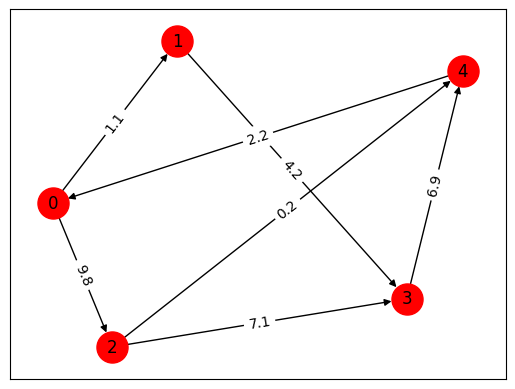

In [5]:
gb.viz.draw(A)

In [13]:
A << A.apply(unary.one)
d_out = A.reduce_rowwise(monoid.plus).new() # считаем кол-во исходящих ребер из каждой вершины
pagerank(A, d_out)

("v_2"      nvals  size  dtype  format
 gb.Vector      5     5   FP32    full
 -------------------------------------
 index         0         1         2         3         4
 value  0.254212  0.138031  0.138031  0.205973  0.263752,
 36)

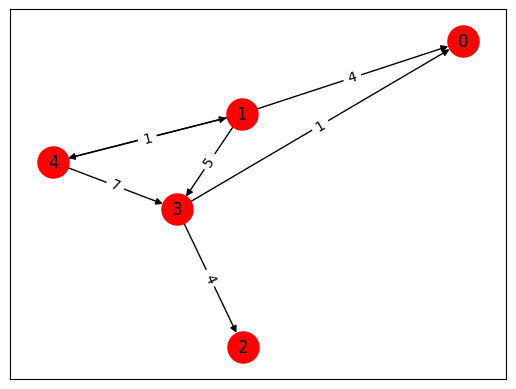

In [58]:
adjacency_matrix2 = np.array([
    [0, 0, 0, 0, 0],
    [4, 0, 0, 5, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 4, 0, 0],
    [0, 1, 0, 7, 0]

])

graph2 = gb.Matrix.from_dense(adjacency_matrix2,missing_value=0)
gb.viz.draw(graph2)

In [59]:
graph2 << graph2.apply(unary.one)
d_out = graph2.reduce_rowwise(monoid.plus).new() # считаем кол-во исходящих ребер из каждой вершины
pagerank(graph2, d_out)

("v_263"    nvals  size  dtype  format
 gb.Vector      5     5   FP32    full
 -------------------------------------
 index         0         1         2         3         4
 value  0.070293  0.048606  0.056518  0.062381  0.043775,
 9)

Результат функции показывает, что вершины 0 и 3 наиболее важные, что в целом видно и на изображении графа

Также можно посчитать Google матрицу (2 формула в лекции)

In [9]:
def google_matrix(M, beta=0.85):
  n = M.nrows
  #teleport = (1 - beta) / n

  B = gb.Matrix(float, n, n)
  for i in range (n):
    for j in range (n):
      B[i, j] = 1/n
  return beta*M + (1-beta)*B

In [10]:
google_matrix(A)

gb.MatrixExpression                       nrows  ncols  dtype
M_2.ewise_add(M_3, op=binary.plus[FP64])      5      5   FP64

"Result"   nvals  nrows  ncols  dtype
gb.Matrix     25      5      5   FP64
-------------------------------------
      0      1     2      3      4
0  0.03  0.965  8.36   0.03   0.03
1  0.03   0.03  0.03    3.6   0.03
2  0.03   0.03  0.03  6.065    0.2
3  0.03   0.03  0.03   0.03  5.895
4   1.9   0.03  0.03   0.03   0.03

Do expr.new() or other << expr to calculate the expression.